In [1]:
!pip install mlflow


# Load Processed Data

In [3]:
import pandas as pd
import numpy as np
import os
import joblib
import logging
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from scipy import sparse

# Setup logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Create directories
os.makedirs('models/fraud_data', exist_ok=True)
os.makedirs('models/credit_card_data', exist_ok=True)
logger.info("Model directories created.")

# Load data
fraud_data = pd.read_csv('../data/processed/cleaned_fraud_data_by_country.csv') 
credit_card_data = pd.read_csv('../data/processed/cleaned_credit_card_data.csv')

# Datetime features for fraud data
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

fraud_data['signup_hour'] = fraud_data['signup_time'].dt.hour
fraud_data['signup_day'] = fraud_data['signup_time'].dt.day
fraud_data['signup_month'] = fraud_data['signup_time'].dt.month
fraud_data['signup_year'] = fraud_data['signup_time'].dt.year

fraud_data['purchase_hour'] = fraud_data['purchase_time'].dt.hour
fraud_data['purchase_day'] = fraud_data['purchase_time'].dt.day
fraud_data['purchase_month'] = fraud_data['purchase_time'].dt.month
fraud_data['purchase_year'] = fraud_data['purchase_time'].dt.year

fraud_data = fraud_data.drop(columns=['signup_time', 'purchase_time'])

# Frequency encoding for categorical columns
cat_cols = fraud_data.select_dtypes(include='object').columns
for col in cat_cols:
    freq_map = fraud_data[col].value_counts().to_dict()
    fraud_data[col] = fraud_data[col].map(freq_map)

# Downcast numeric types
for col in fraud_data.select_dtypes(include='int64'):
    fraud_data[col] = fraud_data[col].astype('int32')
for col in fraud_data.select_dtypes(include='float64'):
    fraud_data[col] = fraud_data[col].astype('float32')

# Separate features and targets
X_fraud = fraud_data.drop(columns=['class'])
y_fraud = fraud_data['class']

X_credit = credit_card_data.drop(columns=['Class'])
y_credit = credit_card_data['Class']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_fraud = imputer.fit_transform(X_fraud)
X_credit = imputer.fit_transform(X_credit)

y_fraud = y_fraud.fillna(y_fraud.mode()[0])
y_credit = y_credit.fillna(y_credit.mode()[0])

# Convert to sparse for fraud (optional)
X_fraud_sparse = sparse.csr_matrix(X_fraud)

# Train/test split
from sklearn.model_selection import train_test_split

X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(X_fraud_sparse, y_fraud, test_size=0.2, random_state=42)
X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(X_credit, y_credit, test_size=0.2, random_state=42)

logger.info("Data loading and preprocessing complete.")


2025-07-27 13:38:08,872 - INFO - Model directories created.


2025-07-27 13:38:15,559 - INFO - Data loading and preprocessing complete.


# I Have Selected 3 Model for Comparing Performance 
1) Decison Tree
2) logistic Regression 
3) Random Forest !!

### Model Training and Evaluation

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import mlflow
import mlflow.sklearn

# Setup MLflow
mlflow.set_tracking_uri("file:///mlruns")
mlflow.set_experiment("Fraud and Credit Card Detection")

# Define only the required models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
}

# Define the train and eval function
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, dataset_name, model_name):
    with mlflow.start_run(run_name=f'{model_name} on {dataset_name}'):
        logger.info(f"Training {model_name} on {dataset_name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)

        mlflow.log_params({
            'model': model_name,
            'dataset': dataset_name,
            'test_size': 0.2,
            'random_state': 42
        })
        mlflow.log_metric('accuracy', accuracy)
        mlflow.sklearn.log_model(model, f'{model_name}_mlflow')

        # Save locally
        save_path = f"models/{dataset_name.lower().replace(' ', '_')}/{model_name.lower().replace(' ', '_')}.joblib"
        joblib.dump(model, save_path)
        logger.info(f"Saved {model_name} to {save_path}")

        # Output results
        print(f"\n📊 Model: {model_name} | Dataset: {dataset_name}")
        print(f"✅ Accuracy: {accuracy:.4f}")
        print(report)
        print("=" * 60)

# Run on Fraud Data
for name, model in models.items():
    train_and_evaluate_model(model, X_train_fraud, y_train_fraud, X_test_fraud, y_test_fraud, 'Fraud Data', name)

# Run on Credit Card Data
for name, model in models.items():
    train_and_evaluate_model(model, X_train_credit, y_train_credit, X_test_credit, y_test_credit, 'Credit Card Data', name)


2025-07-21 21:12:35,928 - DEBUG - Popen(['git', 'version'], cwd=c:\Users\HP\10 Acadamy PRojects\New folder (8 & 9)\Ehanced_Fraud_Detection_Ecommerce_Banking\notebooks, stdin=None, shell=False, universal_newlines=False)
2025-07-21 21:12:36,262 - DEBUG - Popen(['git', 'version'], cwd=c:\Users\HP\10 Acadamy PRojects\New folder (8 & 9)\Ehanced_Fraud_Detection_Ecommerce_Banking\notebooks, stdin=None, shell=False, universal_newlines=False)
2025-07-21 21:12:36,480 - DEBUG - Popen(['git', 'check-ignore', 'c:\\Users\\HP\\10 Acadamy PRojects\\New folder (8 & 9)\\Ehanced_Fraud_Detection_Ecommerce_Banking\\.venv\\Lib\\site-packages'], cwd=c:\Users\HP\10 Acadamy PRojects\New folder (8 & 9)\Ehanced_Fraud_Detection_Ecommerce_Banking, stdin=None, shell=False, universal_newlines=False)
2025-07-21 21:12:37,107 - INFO - Training Logistic Regression on Fraud Data
2025/07/21 21:12:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/21 21:13:15 WARNING mlflow.mo


📊 Model: Logistic Regression | Dataset: Fraud Data
✅ Accuracy: 0.6478
              precision    recall  f1-score   support

           0       0.95      0.64      0.77     27373
           1       0.17      0.70      0.27      2850

    accuracy                           0.65     30223
   macro avg       0.56      0.67      0.52     30223
weighted avg       0.88      0.65      0.72     30223



2025/07/21 21:14:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/21 21:14:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-07-21 21:14:42,803 - INFO - Saved Decision Tree to models/fraud_data/decision_tree.joblib



📊 Model: Decision Tree | Dataset: Fraud Data
✅ Accuracy: 0.9211
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     27373
           1       0.58      0.59      0.59      2850

    accuracy                           0.92     30223
   macro avg       0.77      0.77      0.77     30223
weighted avg       0.92      0.92      0.92     30223



2025-07-21 21:14:43,088 - INFO - Training Random Forest on Fraud Data
2025/07/21 21:28:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/21 21:29:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-07-21 21:29:09,453 - INFO - Saved Random Forest to models/fraud_data/random_forest.joblib



📊 Model: Random Forest | Dataset: Fraud Data
✅ Accuracy: 0.9565
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27373
           1       1.00      0.54      0.70      2850

    accuracy                           0.96     30223
   macro avg       0.98      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223



2025-07-21 21:29:09,743 - INFO - Training Logistic Regression on Credit Card Data
c:\Users\HP\10 Acadamy PRojects\New folder (8 & 9)\Ehanced_Fraud_Detection_Ecommerce_Banking\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/07/21 21:30:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/21 21:31:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-07-21 21:31:02,311 - I


📊 Model: Logistic Regression | Dataset: Credit Card Data
✅ Accuracy: 0.9767
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56656
           1       0.06      0.89      0.11        90

    accuracy                           0.98     56746
   macro avg       0.53      0.93      0.55     56746
weighted avg       1.00      0.98      0.99     56746



2025-07-21 21:31:02,886 - INFO - Training Decision Tree on Credit Card Data
2025/07/21 21:31:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/21 21:32:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-07-21 21:32:13,159 - INFO - Saved Decision Tree to models/credit_card_data/decision_tree.joblib



📊 Model: Decision Tree | Dataset: Credit Card Data
✅ Accuracy: 0.9989
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.66      0.63      0.64        90

    accuracy                           1.00     56746
   macro avg       0.83      0.82      0.82     56746
weighted avg       1.00      1.00      1.00     56746



2025-07-21 21:32:13,451 - INFO - Training Random Forest on Credit Card Data
2025/07/21 21:38:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/21 21:39:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-07-21 21:39:02,219 - INFO - Saved Random Forest to models/credit_card_data/random_forest.joblib



📊 Model: Random Forest | Dataset: Credit Card Data
✅ Accuracy: 0.9995
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.97      0.71      0.82        90

    accuracy                           1.00     56746
   macro avg       0.98      0.86      0.91     56746
weighted avg       1.00      1.00      1.00     56746



## Model Explainability 

# Load Trained Fraud Model

In [12]:
import shap
import joblib
import matplotlib.pyplot as plt

# Load the best-performing fraud model
fraud_model = joblib.load("models/fraud_data/random_forest.joblib")  # update path if needed

# Prepare numeric test data
X_test_fraud_numeric = X_test_fraud.select_dtypes(include='number')


Generate SHAP Values (Fixing Additivity Error)

In [13]:
# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(fraud_model)

# Compute SHAP values with additivity check turned off
shap_values = explainer.shap_values(X_test_fraud_numeric, check_additivity=False)


# Summary plot to see feature importance across the dataset


2025-07-28 22:25:03,149 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-07-28 22:25:03,253 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-07-28 22:25:04,095 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-07-28 22:25:04,191 - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\HP\\10 Acadamy PRojects\\New folder (8 & 9)\\Ehanced_Fraud_Detection_Ecommerce_Banking\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-07-28 22:25:04,195 - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\HP\\10 Acadamy PRojects\\New folder (8 & 9)\\Ehanced_Fraud_Detection_Ecommerce_Banking\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style=

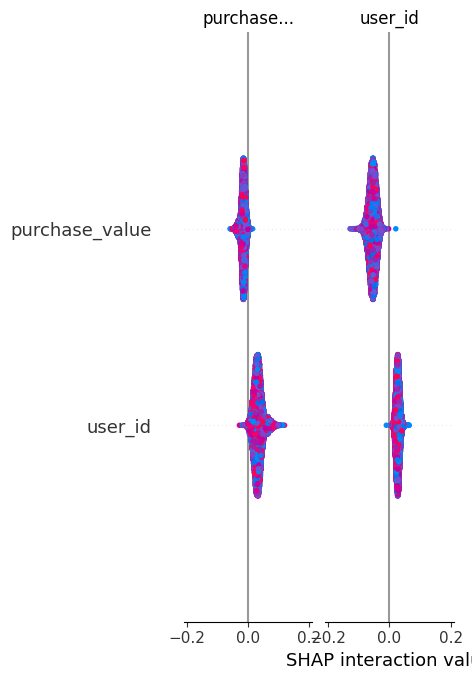

In [14]:
# Summary plot to see feature importance across the dataset
shap.summary_plot(shap_values, X_test_fraud_numeric, plot_type="bar")  # global feature importance
